In [1]:
import torch

from gaussiansplatting.scene.gaussian_model import GaussianModel
from gaussiansplatting.scene import Scene
from gaussiansplatting.gaussian_renderer import render

from argparse import ArgumentParser
from gaussiansplatting.arguments import ModelParams, PipelineParams

from argparse import ArgumentParser, Namespace

import os

def get_combined_args(parser : ArgumentParser, model_path):
    # cmdlne_string = sys.argv[1:]
    # cfgfile_string = "Namespace()"
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)

    try:
        cfgfilepath = os.path.join(model_path, "cfg_args")
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file not found at")
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v
    return Namespace(**merged_dict)

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
# op = OptimizationParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument("--skip_train", action="store_true")
parser.add_argument("--skip_test", action="store_true")
parser.add_argument("--quiet", action="store_true")

parser.add_argument("--threshold", default=0.7, type=float, help='threshold of label voting') #0.7 
parser.add_argument("--gd_interval", default=5, type=int, help='interval of performing gaussian decomposition')

## choose your trained 3D-GS model path
model_path = '/home/niranjanar/masterThesis/SAGS/output'
args = get_combined_args(parser, model_path)

# Initialize system state (RNG)
# safe_state(args.quiet)

# 3D gaussians
dataset = model.extract(args)
dataset.model_path = args.model_path
gaussians = GaussianModel(dataset.sh_degree)
scene = Scene(dataset, gaussians, load_iteration=args.iteration, shuffle=False)

cameras = scene.getTrainCameras()

dataset.white_background = True
bg_color = [1,1,1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

xyz = gaussians.get_xyz

Looking for config file in /home/niranjanar/masterThesis/SAGS/output/cfg_args
Config file found: /home/niranjanar/masterThesis/SAGS/output/cfg_args
Loading trained model at iteration 30000
Reading camera 56/56
Loading Training Cameras
[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1
Loading Test Cameras


In [2]:
import torch.nn.functional as F
import torchvision.transforms.functional as func

from seg_utils import conv2d_matrix, compute_ratios, update

def get_3d_prompts(prompts_2d, point_image, xyz, depth=None):
    r = 4
    x_range = torch.arange(prompts_2d[0] - r, prompts_2d[0] + r)
    y_range = torch.arange(prompts_2d[1] - r, prompts_2d[1] + r)
    x_grid, y_grid = torch.meshgrid(x_range, y_range)
    neighbors = torch.stack([x_grid, y_grid], dim=2).reshape(-1, 2).to("cuda")
    prompts_index = [torch.where((point_image == p).all(dim=1))[0] for p in neighbors]
    indexs = []
    for index in prompts_index:
        if index.nelement() > 0:
            indexs.append(index)
    indexs = torch.unique(torch.cat(indexs, dim=0))
    indexs_depth = depth[indexs]
    valid_depth = indexs_depth[indexs_depth > 0]
    _, sorted_indices = torch.sort(valid_depth)
    valid_indexs = indexs[depth[indexs] > 0][sorted_indices[0]]
    
    return xyz[valid_indexs][:3].unsqueeze(0)

## Given 1st view point prompts, find corresponding 3D Gaussian point prompts
def generate_3d_prompts(xyz, viewpoint_camera, prompts_2d):
    w2c_matrix = viewpoint_camera.world_view_transform
    full_matrix = viewpoint_camera.full_proj_transform
    # project to image plane
    xyz = F.pad(input=xyz, pad=(0, 1), mode='constant', value=1)
    p_hom = (xyz @ full_matrix).transpose(0, 1)  # N, 4 -> 4, N
    p_w = 1.0 / (p_hom[-1, :] + 0.0000001)
    p_proj = p_hom[:3, :] * p_w
    # project to camera space
    p_view = (xyz @ w2c_matrix[:, :3]).transpose(0, 1)  # N, 3 -> 3, N
    depth = p_view[-1, :].detach().clone()
    valid_depth = depth >= 0

    h = viewpoint_camera.image_height
    w = viewpoint_camera.image_width

    point_image = 0.5 * ((p_proj[:2] + 1) * torch.tensor([w, h]).unsqueeze(-1).to(p_proj.device) - 1)
    point_image = point_image.detach().clone()
    point_image = torch.round(point_image.transpose(0, 1)).long()

    prompts_2d = torch.tensor(prompts_2d).to("cuda")
    prompts_3d = []
    for i in range(prompts_2d.shape[0]):
        prompts_3d.append(get_3d_prompts(prompts_2d[i], point_image, xyz, depth))
    prompts_3D = torch.cat(prompts_3d, dim=0)

    return prompts_3D

## Project 3D points to 2D plane
def porject_to_2d(viewpoint_camera, points3D):
    full_matrix = viewpoint_camera.full_proj_transform  # w2c @ K 
    # project to image plane
    if points3D.shape[-1] != 4:
        points3D = F.pad(input=points3D, pad=(0, 1), mode='constant', value=1)
    p_hom = (points3D @ full_matrix).transpose(0, 1)  # N, 4 -> 4, N   -1 ~ 1
    p_w = 1.0 / (p_hom[-1, :] + 0.0000001)
    p_proj = p_hom[:3, :] * p_w

    h = viewpoint_camera.image_height
    w = viewpoint_camera.image_width

    point_image = 0.5 * ((p_proj[:2] + 1) * torch.tensor([w, h]).unsqueeze(-1).to(p_proj.device) - 1) # image plane
    point_image = point_image.detach().clone()
    point_image = torch.round(point_image.transpose(0, 1))

    return point_image

## Single view assignment
def mask_inverse(xyz, viewpoint_camera, sam_mask):
    w2c_matrix = viewpoint_camera.world_view_transform
    # project to camera space
    xyz = F.pad(input=xyz, pad=(0, 1), mode='constant', value=1)
    p_view = (xyz @ w2c_matrix[:, :3]).transpose(0, 1)  # N, 3 -> 3, N
    depth = p_view[-1, :].detach().clone()
    valid_depth = depth >= 0

    h = viewpoint_camera.image_height
    w = viewpoint_camera.image_width
    

    if sam_mask.shape[0] != h or sam_mask.shape[1] != w:
        sam_mask = func.resize(sam_mask.unsqueeze(0), (h, w), antialias=True).squeeze(0).long()
    else:
        sam_mask = sam_mask.long()

    point_image = porject_to_2d(viewpoint_camera, xyz)
    point_image = point_image.long()

    # 判断x,y是否在图像范围之内
    valid_x = (point_image[:, 0] >= 0) & (point_image[:, 0] < w)
    valid_y = (point_image[:, 1] >= 0) & (point_image[:, 1] < h)
    valid_mask = valid_x & valid_y & valid_depth
    point_mask = torch.full((point_image.shape[0],), -1).to("cuda")

    point_mask[valid_mask] = sam_mask[point_image[valid_mask, 1], point_image[valid_mask, 0]]
    indices_mask = torch.where(point_mask == 1)[0]

    return point_mask, indices_mask

## Multi-view label voting
def ensemble(multiview_masks, threshold=0.7):
    # threshold = 0.7
    multiview_masks = torch.cat(multiview_masks, dim=1)
    vote_labels,_ = torch.mode(multiview_masks, dim=1)
    # # select points with score > threshold 
    matches = torch.eq(multiview_masks, vote_labels.unsqueeze(1))
    ratios = torch.sum(matches, dim=1) / multiview_masks.shape[1]
    ratios_mask = ratios > threshold
    labels_mask = (vote_labels == 1) & ratios_mask
    indices_mask = torch.where(labels_mask)[0].detach().cpu()

    return vote_labels, indices_mask

## Gaussian Decomposition
def gaussian_decomp(gaussians, viewpoint_camera, input_mask, indices_mask):
    xyz = gaussians.get_xyz
    point_image = porject_to_2d(viewpoint_camera, xyz)

    conv2d = conv2d_matrix(gaussians, viewpoint_camera, indices_mask, device="cuda")
    height = viewpoint_camera.image_height
    width = viewpoint_camera.image_width
    index_in_all, ratios, dir_vector = compute_ratios(conv2d, point_image, indices_mask, input_mask, height, width)

    decomp_gaussians = update(gaussians, viewpoint_camera, index_in_all, ratios, dir_vector)

    return decomp_gaussians
    

## Prepare SAM predictor

In [3]:
import numpy as np
from segment_anything import (SamAutomaticMaskGenerator, SamPredictor,
                              sam_model_registry)
from seg_utils import grounding_dino_prompt

SAM_ARCH = 'vit_h'
SAM_CKPT_PATH = '/home/niranjanar/masterThesis/SAGS/gaussiansplatting/dependencies/sam_ckpt/sam_vit_h_4b8939.pth'

model_type = SAM_ARCH
sam = sam_model_registry[model_type](checkpoint=SAM_CKPT_PATH).to('cuda')
predictor = SamPredictor(sam)

# text guided
def text_prompting(image, text, id):
    input_boxes = grounding_dino_prompt(image, text)

    boxes = torch.tensor(input_boxes)[0:1].cuda()
    transformed_boxes = predictor.transform.apply_boxes_torch(boxes, image.shape[:2])
    masks,  _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=True,
    )

    masks = masks[0].cpu().numpy()
    return_mask = (masks[id, :, :, None]*255).astype(np.uint8)
    return return_mask / 255
def text_prompting_all_houses(image, text="a house"):
    input_boxes = grounding_dino_prompt(image, text)  # Should return list or array of boxes

    input_boxes = np.array(input_boxes)
    if input_boxes is None or input_boxes.size == 0:
        print("No boxes found.")
        return []

    boxes = torch.tensor(input_boxes).cuda()
    transformed_boxes = predictor.transform.apply_boxes_torch(boxes, image.shape[:2])

    # Get one mask per box
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,  # Only one mask per box (best match)
    )

    # Return as a list of 2D numpy masks
    return [mask[0].cpu().numpy() for mask in masks]  # Each mask: H x W
# point guided
def self_prompt(point_prompts, sam_feature, id):
    input_point = point_prompts.detach().cpu().numpy()
    # input_point = input_point[::-1]
    input_label = np.ones(len(input_point))

    predictor.features = sam_feature
    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    # return_mask = (masks[ :, :, 0]*255).astype(np.uint8)
    return_mask = (masks[id, :, :, None]*255).astype(np.uint8)

    return return_mask / 255

In [4]:
import cv2
import numpy as np
from tqdm import tqdm

sam_features = {}
render_images = {}
print("Prepocessing: extracting SAM features...")
for view in tqdm(cameras):
    image_name = view.image_name
    render_pkg = render(view, gaussians, pipeline, background)

    render_image = render_pkg["render"].permute(1, 2, 0).detach().cpu().numpy()
    render_image = (255 * np.clip(render_image, 0, 1)).astype(np.uint8)

    predictor.set_image(render_image)
    sam_features[image_name] = predictor.features

Prepocessing: extracting SAM features...


100%|██████████| 56/56 [00:34<00:00,  1.62it/s]


## Select point prompts given the first view

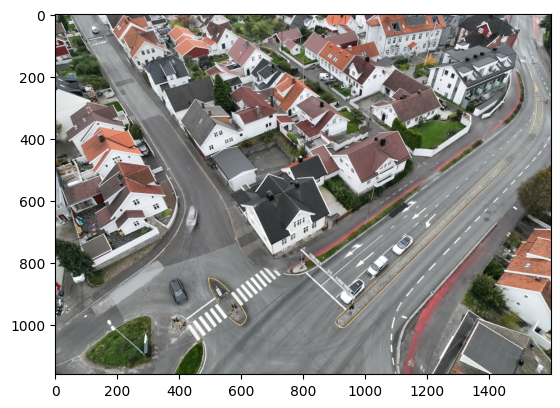

In [5]:
from matplotlib import pyplot as plt

# first view
idx = 17
view = cameras[idx]
render_pkg = render(view, gaussians, pipeline, background)

render_image = render_pkg["render"].permute(1, 2, 0).detach().cpu().numpy()
render_image = (255 * np.clip(render_image, 0, 1)).astype(np.uint8)

plt.imshow(render_image)

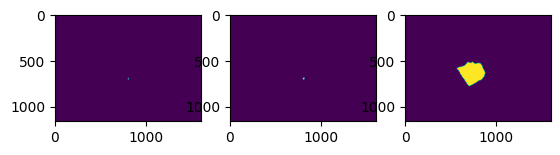

In [6]:
## can select input points from 1st view
input_point = (np.asarray([[800, 700]])).astype(np.int32)
# input_point = (np.asarray([[1200, 700]])).astype(np.int32)
input_label = np.ones(len(input_point))

predictor.set_image(render_image)
with torch.no_grad():
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )

plt.subplot(1,3,1)
plt.imshow(masks[0])
plt.subplot(1,3,2)
plt.imshow(masks[1])
plt.subplot(1,3,3)
plt.imshow(masks[2])

## Start Segmentation

In [7]:
print("Start Segmentation...")

from plyfile import PlyData, PlyElement
import copy

print("Start Segmentation...")

from plyfile import PlyData, PlyElement
import copy

def save_gs(pc, indices_mask, save_path):
    xyz = pc._xyz.detach().cpu()[indices_mask].numpy()
    normals = np.zeros_like(xyz)
    f_dc = pc._features_dc.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu()[indices_mask].numpy()
    f_rest = pc._features_rest.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu()[indices_mask].numpy()
    opacities = pc._opacity.detach().cpu()[indices_mask].numpy()
    scale = pc._scaling.detach().cpu()[indices_mask].numpy()
    rotation = pc._rotation.detach().cpu()[indices_mask].numpy()

    dtype_full = [(attribute, 'f4') for attribute in pc.construct_list_of_attributes()]
    elements = np.empty(xyz.shape[0], dtype=dtype_full)
    attributes = np.concatenate((xyz, normals, f_dc, f_rest, opacities, scale, rotation), axis=1)
    elements[:] = list(map(tuple, attributes))
    el = PlyElement.describe(elements, 'vertex')
    PlyData([el]).write(save_path)

from tqdm import tqdm

multiview_masks = []

# Start looping through all views
for i, view in tqdm(enumerate(cameras), total=len(cameras), desc="Segmenting Houses"):

    render_pkg = render(view, gaussians, pipeline, background)
    render_image = render_pkg["render"].permute(1, 2, 0).detach().cpu().numpy()
    render_image = (255 * np.clip(render_image, 0, 1)).astype(np.uint8)

    predictor.set_image(render_image)
    house_masks = text_prompting_all_houses(render_image, text="a house")  # Gets multiple masks

    all_view_masks = []
    for house_mask in house_masks:
        mask_tensor = torch.tensor(house_mask).squeeze().to("cuda")
        point_mask, _ = mask_inverse(xyz, view, mask_tensor)
        all_view_masks.append(point_mask.unsqueeze(-1))  # Shape: [num_points, 1]

    # Combine all masks in this view
    if all_view_masks:
        view_mask = torch.max(torch.cat(all_view_masks, dim=1), dim=1)[0]
    else:
        view_mask = torch.full((xyz.shape[0],), -1).to("cuda")

    multiview_masks.append(view_mask.unsqueeze(-1))  # Shape: [num_points, 1]

# Multi-view label ensemble
_, final_mask = ensemble(multiview_masks, threshold=args.threshold)

# Save segmented Gaussians
save_path = os.path.join(model_path, 'point_cloud/iteration_30000/point_cloud_houses.ply')
save_gs(gaussians, final_mask, save_path)

print(f"Saved segmented houses to: {save_path}")


Start Segmentation...
Start Segmentation...


Segmenting Houses:   0%|          | 0/56 [00:00<?, ?it/s]UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


final text_encoder_type: bert-base-uncased


Segmenting Houses:   2%|▏         | 1/56 [00:02<02:40,  2.91s/it]

boxes device cpu
[[1.3432267e+03 1.3119810e+02 1.5909459e+03 3.0960919e+02]
 [7.0288135e+02 1.0514514e+02 8.9256470e+02 2.4998050e+02]
 [4.9754401e+02 3.0420438e+02 7.3988678e+02 4.6175388e+02]
 [1.1700592e+00 4.3359290e+02 1.6725763e+02 6.3023962e+02]
 [2.7302109e+02 9.1023584e+02 6.7631494e+02 1.1560154e+03]
 [3.1995544e+02 5.4382439e+01 4.7641919e+02 1.7554398e+02]
 [7.6996350e+02 3.5801047e+02 1.0398832e+03 6.2901208e+02]
 [9.1793475e+02 9.5751349e+02 1.2232273e+03 1.1561163e+03]
 [4.9732190e+02 9.5362000e+01 6.1409387e+02 2.1754291e+02]
 [9.3564905e+02 1.3494568e+02 1.1095211e+03 2.7829907e+02]
 [2.3622513e+00 7.3482922e+02 2.5358765e+02 1.0023240e+03]
 [5.2986731e+02 6.6568280e+02 8.3981506e+02 9.7871576e+02]
 [1.2942812e+02 1.2011475e+01 3.1851416e+02 1.2762746e+02]
 [2.4329285e+01 3.1791757e+02 3.9654688e+02 4.9714066e+02]
 [8.3293036e+02 4.9967957e-01 9.2956757e+02 7.2556305e+01]
 [1.0302517e+03 7.0974023e+02 1.3318450e+03 9.7017224e+02]]
final text_encoder_type: bert-base-unc

Segmenting Houses:   4%|▎         | 2/56 [00:05<02:28,  2.74s/it]

final text_encoder_type: bert-base-uncased


Segmenting Houses:   5%|▌         | 3/56 [00:08<02:21,  2.66s/it]

boxes device cpu
[[1.3506781e+03 1.3254860e+02 1.5959425e+03 3.1186615e+02]
 [7.0419476e+02 1.0748857e+02 8.9751483e+02 2.4702025e+02]
 [4.9319733e+02 3.0067957e+02 7.3408966e+02 4.6167523e+02]
 [8.9111914e+02 9.6249756e+02 1.1996609e+03 1.1562759e+03]
 [3.2649414e+02 4.8069920e+01 4.8321729e+02 1.7015756e+02]
 [2.4730298e+02 9.0809723e+02 6.5397723e+02 1.1558975e+03]
 [1.3174667e+00 4.2523294e+02 1.6591403e+02 6.2723029e+02]
 [7.6154425e+02 3.5764868e+02 1.0361804e+03 6.3507422e+02]
 [5.1307104e+02 6.6523083e+02 8.2259985e+02 9.8095422e+02]
 [1.3820634e+02 6.3320503e+00 3.2565771e+02 1.2228937e+02]
 [4.9892734e+02 9.0925720e+01 6.1902112e+02 2.1447009e+02]
 [9.3680579e+02 1.3420044e+02 1.1139784e+03 2.7771799e+02]
 [2.4064148e+01 3.1195279e+02 3.9374063e+02 4.9051181e+02]
 [4.2822260e+02 5.4687119e-01 5.4489551e+02 8.0261078e+01]
 [8.3976129e+02 3.2516861e-01 9.3740277e+02 6.9936172e+01]
 [1.5432816e+00 7.2910950e+02 2.3746652e+02 9.9108374e+02]]
final text_encoder_type: bert-base-unc

Segmenting Houses:   7%|▋         | 4/56 [00:10<02:22,  2.74s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[1.40522998e+03 1.69748856e+02 1.59837939e+03 3.61089478e+02]
 [5.05743805e+02 2.89258331e+02 7.38872559e+02 4.51019501e+02]
 [7.46481201e+02 1.11581955e+02 9.39287720e+02 2.51411392e+02]
 [4.35910156e+02 6.60192505e+02 7.54493652e+02 9.66646729e+02]
 [1.54947327e+02 8.80102539e+02 5.02717224e+02 1.15669556e+03]
 [1.17720795e+00 3.81842102e+02 1.79653900e+02 5.75855774e+02]
 [3.98515411e+02 3.72833252e+01 5.52268555e+02 1.55327988e+02]
 [9.69397827e+02 1.45006088e+02 1.15800720e+03 2.98505859e+02]
 [7.55243103e+02 9.78986389e+02 1.07400879e+03 1.15687207e+03]
 [9.22374695e+02 7.45413940e+02 1.24082593e+03 1.02296204e+03]
 [3.20198364e+01 2.01407700e+02 2.40027893e+02 3.58501770e+02]
 [1.32342529e+00 6.69139404e+02 1.94698792e+02 8.92578979e+02]
 [2.28879944e+02 1.09616089e+00 4.02406128e+02 1.00735817e+02]
 [7.35465698e+01 2.81522583e+02 4.14937286e+02 4.56306580e+02]
 [9.11217651e+02 5.67546844e-01 1.01531299e+03 7.95965576e

Segmenting Houses:   9%|▉         | 5/56 [00:13<02:16,  2.67s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[7.83395020e+02 1.12086761e+02 9.77839600e+02 2.58935089e+02]
 [1.45271204e+03 2.07025421e+02 1.59762756e+03 4.07416656e+02]
 [5.20545532e+02 2.78067993e+02 7.49951660e+02 4.41400818e+02]
 [3.85477570e+02 6.52242676e+02 7.01258057e+02 9.47980225e+02]
 [8.49140137e+02 7.64047729e+02 1.18413220e+03 1.05365833e+03]
 [1.59217072e+00 3.43663879e+02 2.01485718e+02 5.37162598e+02]
 [9.99514038e+02 1.57670197e+02 1.19708191e+03 3.17326996e+02]
 [4.58878052e+02 3.06615791e+01 6.10135132e+02 1.43481003e+02]
 [1.64107513e+00 6.20741333e+02 1.74752197e+02 8.26987549e+02]
 [9.31300659e+01 8.39097290e+02 4.21128967e+02 1.15603833e+03]
 [9.73389404e+02 1.49980545e+00 1.07904712e+03 9.14110107e+01]
 [1.09173413e+03 9.08893890e+01 1.25312964e+03 2.31360245e+02]
 [6.40499634e+02 5.82060059e+02 8.25847046e+02 7.68995728e+02]
 [3.33303833e+00 1.07594810e+02 2.83865204e+02 3.22291168e+02]
 [1.08140663e+02 5.00164795e+02 3.58314667e+02 6.77206665e

Segmenting Houses:  11%|█         | 6/56 [00:16<02:14,  2.69s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[8.32722046e+02 1.20834038e+02 1.02877051e+03 2.68179047e+02]
 [5.44595825e+02 2.67192993e+02 7.62880371e+02 4.34644287e+02]
 [1.03919897e+03 1.75587433e+02 1.24893335e+03 3.43009308e+02]
 [7.70417725e+02 7.84114441e+02 1.11448364e+03 1.08224866e+03]
 [5.02923065e+02 9.80479065e+02 8.51577637e+02 1.15838892e+03]
 [3.40661255e+02 6.38774780e+02 6.50096313e+02 9.15712280e+02]
 [5.34367737e+02 2.37722626e+01 6.88097229e+02 1.33558624e+02]
 [1.15121191e+03 1.13485359e+02 1.32264746e+03 2.60741089e+02]
 [3.85291977e+01 3.04866760e+02 2.34621277e+02 4.73937561e+02]
 [6.03718750e+02 5.81422729e+02 7.97072998e+02 7.62295532e+02]
 [1.07682343e+01 7.87852844e+02 3.44458435e+02 1.12719775e+03]
 [1.51472119e+03 2.79165558e+02 1.59817383e+03 4.49390045e+02]
 [3.34284882e+02 3.89034546e+02 5.64799561e+02 5.60114807e+02]
 [1.04998157e+03 1.22303429e+01 1.16215222e+03 1.06268478e+02]
 [1.02021027e+00 5.13731689e+01 1.18599815e+02 2.26209961e

Segmenting Houses:  12%|█▎        | 7/56 [00:18<02:08,  2.63s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[8.9291138e+02 1.2994528e+02 1.0923314e+03 2.8023413e+02]
 [3.7476965e+02 9.6783289e+02 7.1711438e+02 1.1578868e+03]
 [1.0876807e+03 2.0177451e+02 1.3148103e+03 3.7812650e+02]
 [6.8244189e+02 7.9972937e+02 1.0243755e+03 1.1028282e+03]
 [5.7763068e+02 2.5795792e+02 7.8712262e+02 4.3053836e+02]
 [6.5409949e+02 3.9166757e+02 1.0158281e+03 6.7427429e+02]
 [3.0238745e+02 6.1625989e+02 6.0127124e+02 8.7669556e+02]
 [1.2217789e+03 1.4238867e+02 1.4129991e+03 2.9778452e+02]
 [1.1428126e+03 3.2103714e+01 1.2643392e+03 1.3455870e+02]
 [3.5162244e+02 3.6763007e+02 5.7301562e+02 5.2922906e+02]
 [1.0798627e+02 2.6296323e+02 2.9170255e+02 4.2188480e+02]
 [1.3886758e+02 4.2579980e+02 3.6306689e+02 6.1255945e+02]
 [2.3030565e+02 2.0456253e+02 5.1138306e+02 3.7084079e+02]
 [5.7378149e+02 5.7502100e+02 7.6837012e+02 7.4821460e+02]
 [1.2799835e+00 5.0535858e+02 1.7382413e+02 6.8429742e+02]
 [2.3583633e+02 1.1787752e+02 4.2153439e+02 2.4121339e+

Segmenting Houses:  14%|█▍        | 8/56 [00:21<02:04,  2.60s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[ 956.7342     143.38744   1159.9639     302.6505   ]
 [ 255.26991    943.1317     578.9823    1158.674    ]
 [1138.5131     232.34245   1387.7421     421.13275  ]
 [ 662.0791     398.81747   1010.8495     679.23596  ]
 [1296.6228     181.25868   1509.3076     344.91003  ]
 [ 617.30865    250.0965     816.3227     429.0943   ]
 [ 591.9088     810.5894     923.80664   1113.2665   ]
 [ 260.8568     584.4801     554.55066    827.0852   ]
 [ 308.96597    180.5513     559.8447     354.66122  ]
 [ 211.22261    471.0253     485.93182    632.586    ]
 [1446.5718      11.6296425 1583.0803     110.336395 ]
 [ 546.08203    570.5665     737.1542     732.51514  ]
 [1444.3696     144.76323   1589.9963     249.89037  ]
 [   2.2339935  643.17346    292.02478    960.56506  ]
 [1243.2819      59.87656   1378.1691     171.02684  ]
 [ 382.24808    346.75867    588.6493     512.9872   ]
 [ 805.9533      74.74196    959.6761     208.21446  ]
 [ 17

Segmenting Houses:  16%|█▌        | 9/56 [00:23<02:03,  2.62s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[1.3069229e+02 9.0589130e+02 4.5263284e+02 1.1586572e+03]
 [1.0248713e+03 1.6208206e+02 1.2277751e+03 3.3297635e+02]
 [1.1909594e+03 2.7232782e+02 1.4591063e+03 4.7404913e+02]
 [1.3762914e+03 2.3178857e+02 1.5974830e+03 4.0602032e+02]
 [5.0640326e+02 8.0880920e+02 7.9446515e+02 1.1155350e+03]
 [6.8234894e+02 4.0805237e+02 1.0050527e+03 6.8351587e+02]
 [4.1581360e+02 3.2829160e+02 6.0400195e+02 4.8462991e+02]
 [6.5388727e+02 2.4599146e+02 8.3844293e+02 4.3006152e+02]
 [6.9839935e+01 1.5915985e+00 3.0654416e+02 2.3122653e+02]
 [2.3160333e+02 5.5604919e+02 5.0985535e+02 7.7735803e+02]
 [1.3551168e+03 9.4236122e+01 1.5054144e+03 2.2075110e+02]
 [1.1386185e+00 9.9524670e+02 1.4608002e+02 1.1592469e+03]
 [8.1678564e+02 1.8939907e+01 9.2530151e+02 1.2553754e+02]
 [3.9087973e+02 1.6297214e+02 6.1534656e+02 3.2651846e+02]
 [2.1335803e+02 3.5082269e+02 4.0173889e+02 4.7958710e+02]
 [8.9014221e+02 8.4499008e+01 1.0293435e+03 2.1808281e+

Segmenting Houses:  18%|█▊        | 10/56 [00:26<01:58,  2.58s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[1.2444825e+03 3.1837402e+02 1.5336027e+03 5.3437848e+02]
 [1.0940183e+03 1.8718935e+02 1.3013010e+03 3.7240942e+02]
 [5.6275665e+01 8.4772498e+02 3.6940134e+02 1.1588600e+03]
 [6.9696936e+02 4.1024115e+02 9.9834241e+02 6.8467841e+02]
 [4.2088074e+02 7.9209338e+02 6.9275940e+02 1.1083917e+03]
 [6.9735681e+02 2.4570547e+02 8.6472095e+02 3.9456094e+02]
 [1.4582509e+03 2.8985071e+02 1.5979598e+03 4.7740948e+02]
 [4.5712909e+02 3.1368683e+02 6.2901398e+02 4.5345923e+02]
 [4.7067218e+02 1.5096744e+02 6.7817157e+02 3.0956610e+02]
 [9.1832678e+02 2.8642071e+01 1.0251047e+03 1.3513292e+02]
 [9.7590082e+02 9.8433220e+01 1.1082622e+03 2.3405444e+02]
 [5.1777362e+02 5.5882104e+02 6.8735052e+02 6.9267908e+02]
 [2.2731592e+02 5.3971619e+02 4.8498578e+02 7.2643164e+02]
 [1.4730706e+03 1.3785545e+02 1.5978022e+03 2.6438358e+02]
 [1.0812067e+03 5.2255630e-01 1.1910419e+03 9.3914886e+01]
 [1.2197175e+03 6.7963585e+01 1.3268779e+03 1.8242920e+

Segmenting Houses:  20%|█▉        | 11/56 [00:28<01:54,  2.56s/it]

final text_encoder_type: bert-base-uncased


Segmenting Houses:  21%|██▏       | 12/56 [00:31<01:52,  2.55s/it]

boxes device cpu
[[1292.9172     367.61642   1593.7576     596.5779   ]
 [   8.951233   786.4425     323.55005   1090.7174   ]
 [1157.2557     215.72745   1367.7814     413.01547  ]
 [ 348.41534    768.817      640.7211    1083.7777   ]
 [   2.7979965  449.03528    239.68222    700.8871   ]
 [ 725.6642     247.46777    901.6399     440.7202   ]
 [ 700.5939     424.17752    986.4795     684.83875  ]
 [ 504.38007    551.3587     675.4167     673.56805  ]
 [   3.980362   785.2771     325.74512   1155.2537   ]
 [ 232.62651    391.836      512.661      686.3001   ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  23%|██▎       | 13/56 [00:33<01:49,  2.54s/it]

boxes device cpu
[[1.33215173e+03 4.25020660e+02 1.59776038e+03 6.71709351e+02]
 [1.34671021e+00 7.19873169e+02 2.81490570e+02 1.01571826e+03]
 [6.76742554e+02 4.40718933e+02 9.66932129e+02 7.01957458e+02]
 [2.35271362e+02 3.67890381e+02 5.34828552e+02 6.43440491e+02]
 [2.55178101e+02 1.27766441e+02 6.17471741e+02 2.58438873e+02]
 [2.68174377e+02 7.37609619e+02 5.67889282e+02 1.05646899e+03]
 [1.18212433e+01 3.95394012e+02 2.59380493e+02 6.34542480e+02]
 [4.20329651e+02 7.80857086e-01 6.16760437e+02 1.22565979e+02]
 [7.22429260e+02 2.51889191e+02 9.30569641e+02 4.53828339e+02]
 [4.86320190e+02 4.59244812e+02 7.06068115e+02 6.60615540e+02]
 [5.23172913e+02 2.83513306e+02 6.97602356e+02 4.42933411e+02]
 [1.22219739e+03 2.49704788e+02 1.43282458e+03 4.62125061e+02]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  25%|██▌       | 14/56 [00:36<01:45,  2.51s/it]

boxes device cpu
[[1.3636724e+03 5.0978870e+02 1.5980154e+03 7.7831445e+02]
 [6.4196118e+02 4.5672217e+02 9.5613342e+02 7.3141333e+02]
 [1.2871737e+03 3.0257465e+02 1.5031151e+03 5.3449384e+02]
 [4.6768481e+02 5.1057568e+02 6.5147925e+02 6.4990576e+02]
 [9.9641418e-01 6.4620593e+02 2.4032327e+02 9.2000891e+02]
 [3.4063507e+01 3.4688104e+02 2.8783463e+02 5.7183295e+02]
 [1.8616748e+02 6.9569519e+02 4.9168927e+02 1.0122533e+03]
 [5.0698193e+02 6.0515594e-01 7.3389282e+02 1.1332545e+02]
 [7.7582629e+02 6.0044174e+00 9.4810217e+02 1.7180811e+02]
 [2.4068896e+02 3.4507629e+02 5.5759979e+02 6.0758502e+02]
 [7.3749371e+02 2.6476379e+02 9.7073749e+02 4.7600854e+02]
 [5.5150629e+02 2.7327509e+02 7.3445416e+02 4.3851202e+02]
 [5.4996948e+00 2.5888062e+00 9.7856982e+02 7.3467389e+02]]
final text_encoder_type: bert-base-uncased
boxes device cpu
[[6.09628784e+02 4.74464966e+02 9.46111816e+02 7.54715698e+02]
 [1.35723669e+03 3.74845184e+02 1.59076355e+03 5.96169739e+02]
 [1.30137634e+02 6.47380432e+

Segmenting Houses:  27%|██▋       | 15/56 [00:38<01:42,  2.50s/it]

final text_encoder_type: bert-base-uncased


Segmenting Houses:  29%|██▊       | 16/56 [00:41<01:40,  2.52s/it]

boxes device cpu
[[8.4395349e+02 3.0626874e+02 1.0665370e+03 5.2741449e+02]
 [9.8367328e+02 1.9519341e+01 1.1982843e+03 2.2113745e+02]
 [5.7709892e+01 2.0874850e+02 2.4900085e+02 3.8195920e+02]
 [1.1016028e+02 5.9544006e+02 3.9259192e+02 8.7235107e+02]
 [1.1725540e+00 4.9500879e+02 2.2595132e+02 6.9017493e+02]
 [2.9806812e+02 3.3700354e+02 5.4323883e+02 5.3874115e+02]
 [1.4082299e+03 4.5752618e+02 1.5978400e+03 7.3924286e+02]
 [4.6556915e+02 4.6335172e+02 6.4231915e+02 6.1516827e+02]
 [7.4554700e+02 5.7314682e-01 9.7286023e+02 1.1950452e+02]
 [1.3884160e+03 7.3300659e+02 1.5978347e+03 1.0823842e+03]
 [1.8474817e+02 2.5712903e+02 3.8956531e+02 4.5106689e+02]
 [6.6322430e+02 2.5660986e+02 8.4084296e+02 4.0574127e+02]
 [4.3467560e+02 2.6576346e+02 6.3341742e+02 4.3732590e+02]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  30%|███       | 17/56 [00:43<01:38,  2.52s/it]

boxes device cpu
[[5.7552057e+02 5.0037585e+02 9.1883234e+02 7.8352307e+02]
 [9.4546967e+02 2.0067148e+02 1.1567540e+03 3.3898666e+02]
 [1.0884636e+03 5.1910164e+01 1.3369119e+03 2.5980701e+02]
 [8.6656061e+02 3.3772443e+02 1.1119171e+03 5.5942261e+02]
 [1.3147305e+03 8.4322009e+02 1.5975693e+03 1.1605837e+03]
 [8.7380457e+02 7.0339584e-01 1.1286171e+03 1.2710693e+02]
 [1.7136798e+02 1.6595967e+02 3.4268854e+02 3.2731213e+02]
 [7.4161609e+02 7.6340042e+01 9.9432446e+02 2.5327928e+02]
 [7.2067419e+02 2.5886536e+02 8.9804248e+02 4.0956470e+02]
 [1.8385429e+01 4.2790082e+02 2.5177805e+02 5.9988470e+02]
 [5.5508423e+00 1.3030090e+00 1.3358752e+03 7.8516431e+02]
 [1.1636394e+02 5.4073615e+02 3.7135956e+02 7.9133636e+02]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  32%|███▏      | 18/56 [00:46<01:35,  2.53s/it]

boxes device cpu
[[1.1967749e+03 9.6439285e+01 1.4858960e+03 3.1576996e+02]
 [8.8495215e+02 3.7376068e+02 1.1467716e+03 5.8977246e+02]
 [5.6544568e+02 5.0765814e+02 8.8605164e+02 7.8274481e+02]
 [9.9799158e+02 6.4673615e-01 1.2705692e+03 1.4342538e+02]
 [1.0147937e+03 2.3495886e+02 1.2434194e+03 3.7332074e+02]
 [1.4149535e+03 6.8885907e+02 1.5983134e+03 1.0316055e+03]
 [4.0487802e+02 2.4748474e+02 7.1663562e+02 4.7018445e+02]
 [1.2905740e+03 8.4939957e-01 1.4962029e+03 1.1267822e+02]
 [8.4353870e+02 8.3756500e+01 1.0959586e+03 2.7819894e+02]
 [1.2780274e+02 5.1807977e+02 3.6493484e+02 7.1440936e+02]
 [2.8552411e+02 1.3005023e+02 4.3676337e+02 2.8100693e+02]
 [7.6945959e+02 2.6308459e+02 9.4877466e+02 4.0866516e+02]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  34%|███▍      | 19/56 [00:48<01:32,  2.50s/it]

boxes device cpu
[[ 562.45996    505.1198     853.7228     777.66644  ]
 [ 901.5643     416.98544   1175.522      623.98     ]
 [1121.4873       2.9946365 1420.3066     178.7789   ]
 [1369.6252     819.9703    1598.0046    1157.7996   ]
 [1304.8026     159.33908   1597.7291     380.35074  ]
 [ 464.64398    222.7843     763.5035     448.10767  ]
 [ 815.61414    274.63892   1000.6267     419.42682  ]
 [ 945.5943      99.965805  1191.7402     303.7439   ]
 [1087.5216     210.73889   1331.3375     421.41058  ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  36%|███▌      | 20/56 [00:51<01:29,  2.49s/it]

boxes device cpu
[[5.5927197e+02 5.0677942e+02 8.1667578e+02 7.7158850e+02]
 [9.1311841e+02 4.6160352e+02 1.1918027e+03 6.5653748e+02]
 [1.2621749e+03 4.4496681e+01 1.5706324e+03 2.3093134e+02]
 [1.2812351e+03 9.6492395e+02 1.5977222e+03 1.1567916e+03]
 [5.0835330e+02 8.9011871e+01 6.2728931e+02 1.8877902e+02]
 [1.4095854e+03 2.7228326e+02 1.5978040e+03 4.4895105e+02]
 [8.0694481e+01 1.4547272e+00 3.0845288e+02 1.3797205e+02]
 [1.1545074e+03 2.5934146e+02 1.4150775e+03 4.8005984e+02]
 [1.8696509e+02 3.7298303e+02 3.9272693e+02 5.7482648e+02]
 [4.9480475e+02 3.8031616e+00 1.1928936e+03 7.6800775e+02]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  38%|███▊      | 21/56 [00:54<01:28,  2.53s/it]

boxes device cpu
[[ 918.08234   508.62225  1191.4265    696.861   ]
 [ 530.0421    502.1253    771.55896   749.6877  ]
 [1211.6161    320.3237   1485.0763    548.8542  ]
 [ 225.18625   330.5172    436.48      513.2288  ]
 [ 289.57944   227.65582   463.85306   376.33795 ]
 [ 896.7852    317.82913  1082.1855    480.28665 ]
 [1508.9664    350.7743   1598.2941    533.3733  ]
 [  43.562675  115.56154   233.78589   254.79552 ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  39%|███▉      | 22/56 [00:56<01:25,  2.52s/it]

boxes device cpu
[[ 906.7318   548.61127 1185.58     747.9682 ]
 [1259.196    392.38666 1595.1553   680.05   ]
 [ 498.80548  495.4572   753.222    746.4953 ]
 [ 177.65012   79.87975  363.72073  212.5664 ]
 [ 927.45654  348.71524 1111.7125   525.6172 ]
 [ 286.99527  302.03253  485.70706  476.08228]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  41%|████      | 23/56 [00:59<01:25,  2.59s/it]

boxes device cpu
[[ 863.28845   575.76044  1161.5216    809.7493  ]
 [1290.8167    483.27472  1597.7083    793.64716 ]
 [ 342.41833   275.04364   536.8292    442.86884 ]
 [ 468.79144   489.79724   739.9145    746.79675 ]
 [ 290.4923     56.614357  474.4978    186.24796 ]
 [ 795.36475    84.93789   919.50684   198.19427 ]
 [ 941.77124   384.05646  1144.6365    570.9634  ]
 [1341.1631    211.19339  1597.385     413.29355 ]
 [   3.743927  159.42915   411.05685   489.66742 ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  43%|████▎     | 24/56 [01:01<01:22,  2.57s/it]

boxes device cpu
[[ 818.12476   599.15485  1139.0903    867.61285 ]
 [ 400.45126   258.06146   590.5276    418.16467 ]
 [1284.8856    620.844    1598.0162    943.3512  ]
 [ 525.2196    177.63472   680.7645    325.2541  ]
 [ 407.67963    43.764286  589.7303    165.65915 ]
 [ 884.80066    99.08598  1016.93677   219.96388 ]
 [ 455.99127   483.29498   732.966     736.1944  ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  45%|████▍     | 25/56 [01:04<01:19,  2.57s/it]

boxes device cpu
[[1256.941     705.943    1597.8768   1098.055   ]
 [ 763.54675   622.5441   1098.7485    916.93207 ]
 [ 465.77957   244.72406   647.79614   398.51166 ]
 [ 591.4347    169.7998    755.27405   318.34998 ]
 [ 953.81934   459.1405   1200.9902    674.40735 ]
 [ 974.4929    117.58845  1116.8086    246.95245 ]
 [ 522.5672     35.050777  700.3875    161.40562 ]
 [ 659.0765    379.8479    815.4688    518.13403 ]
 [ 723.31415    44.49032   880.64557   196.58893 ]
 [ 866.573     303.7191   1073.0663    465.53152 ]
 [1263.568     707.7285   1597.8959   1035.091   ]]
final text_encoder_type: bert-base-uncased
boxes device cpu
[[7.0972577e+02 6.4194855e+02 1.0481071e+03 9.5698444e+02]
 [1.2058213e+03 7.9773627e+02 1.5975107e+03 1.1575198e+03]
 [5.2650842e+02 2.3303993e+02 7.0194397e+02 3.8482080e+02]
 [6.6343146e+02 1.7304767e+02 8.2641815e+02 3.1833908e+02]
 [9.4897736e+02 5.0015030e+02 1.2114728e+03 7.2909888e+02]
 [1.0594446e+03 1.4674654e+02 1.2138809e+03 2.8279901e+02]
 [1.262

Segmenting Houses:  46%|████▋     | 26/56 [01:06<01:17,  2.58s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[6.51810547e+02 6.54506287e+02 9.76367065e+02 9.85055359e+02]
 [9.06726379e+02 5.45274841e+02 1.20258789e+03 7.81222351e+02]
 [5.80295349e+02 2.29285233e+02 7.52320374e+02 3.75241882e+02]
 [1.13807458e+03 1.81065674e+02 1.30595105e+03 3.24957764e+02]
 [7.30730530e+02 1.78689209e+02 8.92851379e+02 3.21190552e+02]
 [7.34318054e+02 4.02082214e+01 9.07677551e+02 1.63711349e+02]
 [1.11760999e+03 8.91414673e+02 1.59720471e+03 1.15807239e+03]
 [9.21186584e+02 7.02431641e+01 1.07538696e+03 2.29212219e+02]
 [1.28937402e+03 1.15967880e+02 1.48469946e+03 2.70291016e+02]
 [1.24318542e+03 5.88436127e-01 1.40016394e+03 1.11142044e+02]
 [1.83728149e+02 2.84574890e+00 4.24219543e+02 2.71504211e+02]
 [6.99571045e+02 3.91736603e+02 8.58854736e+02 5.22988647e+02]
 [1.10247363e+03 4.83987427e+02 1.35211597e+03 6.78189331e+02]
 [1.33063281e+03 3.37936493e+02 1.59364136e+03 5.13062622e+02]
 [1.08750635e+03 6.23142242e+00 1.22429663e+03 1.31497070e

Segmenting Houses:  48%|████▊     | 27/56 [01:09<01:15,  2.59s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[1020.7674     982.9463    1348.9336    1157.8992   ]
 [ 648.5773     230.1415     806.048      369.88934  ]
 [1218.7738     221.90701   1400.6136     380.62167  ]
 [ 804.46844    193.10204    960.8908     330.85748  ]
 [1400.3679     169.46176   1597.0073     335.4692   ]
 [1387.2831      36.84061   1568.5348     156.10553  ]
 [1106.8005     545.594     1372.0317     745.78076  ]
 [1212.5698      43.762436  1353.3499     167.51883  ]
 [ 914.4204     592.0675    1183.8936     826.4597   ]
 [1021.09595     94.37006   1178.0669     258.49048  ]
 [ 602.0987     657.4057     899.36615    977.6447   ]
 [ 840.11725     53.378033  1015.425      170.80006  ]
 [ 931.45654    403.5311    1188.2273     547.1624   ]
 [ 501.86026    531.9288     680.09875    666.4274   ]
 [ 981.2006     462.09216   1275.3351     609.4523   ]
 [1371.3783     871.7055    1597.5963    1156.2114   ]
 [  43.384346    57.577637   273.34894    243.61624  ]
 [ 72

Segmenting Houses:  50%|█████     | 28/56 [01:12<01:14,  2.65s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[8.76322388e+02 2.10192932e+02 1.02854443e+03 3.43046997e+02]
 [7.07223511e+02 2.33786774e+02 8.63723145e+02 3.67000092e+02]
 [5.58747925e+02 6.50300232e+02 8.13386475e+02 9.57163147e+02]
 [1.10481030e+03 6.07153320e+02 1.37256714e+03 8.14652344e+02]
 [8.78110474e+02 6.33433960e+02 1.14711255e+03 8.66344971e+02]
 [1.29507764e+03 2.73045807e+02 1.49541992e+03 4.44585297e+02]
 [1.30393689e+03 9.95410156e+02 1.59769885e+03 1.15708472e+03]
 [1.35893250e+01 6.56944275e-01 3.82670288e+02 2.10380646e+02]
 [1.28686096e+03 5.80830811e+02 1.56922644e+03 7.53408081e+02]
 [1.33920020e+03 8.22892227e+01 1.49357861e+03 2.15761597e+02]
 [9.45080139e+02 7.34175262e+01 1.12584009e+03 1.82879044e+02]
 [9.02636230e+02 1.05895605e+03 1.18488965e+03 1.15683301e+03]
 [1.12197534e+03 1.24907417e+02 1.28309155e+03 2.89753571e+02]
 [7.49420654e+02 4.13549683e+02 9.00650513e+02 5.30414429e+02]
 [1.51384570e+03 2.72736572e+02 1.59834155e+03 4.13168884e

Segmenting Houses:  52%|█████▏    | 29/56 [01:15<01:14,  2.74s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[1.0849708e+03 6.6975250e+02 1.3471322e+03 8.7620990e+02]
 [4.9896201e+02 6.3802246e+02 7.4623578e+02 9.2180542e+02]
 [9.4133716e+02 2.3335312e+02 1.0902333e+03 3.6513022e+02]
 [7.7623956e+02 2.4844830e+02 9.1044012e+02 3.7592200e+02]
 [1.0444598e+03 1.0210280e+02 1.2313175e+03 2.0893202e+02]
 [1.2891006e+03 6.6260736e+02 1.5853523e+03 8.4860236e+02]
 [1.0834684e+03 2.2593303e+02 1.2406002e+03 3.5885864e+02]
 [8.3977319e+02 6.7038184e+02 1.0901265e+03 8.9478040e+02]
 [1.3644044e+03 3.4325635e+02 1.5784073e+03 5.2023279e+02]
 [4.9173538e+02 4.9680511e+02 6.6770581e+02 6.1619330e+02]
 [7.7085046e+02 4.2830649e+02 9.1439600e+02 5.3958325e+02]
 [1.3942076e+03 5.2003308e+02 1.5979496e+03 6.4345081e+02]
 [1.4657571e+03 1.3403287e+02 1.5984465e+03 2.7631085e+02]
 [9.5396106e+02 4.6359702e+02 1.2214432e+03 5.9616650e+02]
 [9.6103394e+02 5.7156561e+02 1.2847107e+03 6.9045599e+02]
 [7.6734290e+02 1.0972758e+03 1.0378182e+03 1.1581842e+

Segmenting Houses:  54%|█████▎    | 30/56 [01:17<01:10,  2.71s/it]

final text_encoder_type: bert-base-uncased


Segmenting Houses:  55%|█████▌    | 31/56 [01:20<01:06,  2.65s/it]

boxes device cpu
[[1.0458611e+03 7.1950995e+02 1.2956978e+03 9.3194879e+02]
 [9.9842279e+02 2.5912650e+02 1.1417870e+03 3.9254953e+02]
 [1.6920929e+00 1.8078586e+02 1.7184630e+02 3.7624759e+02]
 [1.2732423e+03 7.2907104e+02 1.5714891e+03 9.5270923e+02]
 [7.9858838e+02 6.8408917e+02 1.0199103e+03 9.1032477e+02]
 [4.1899390e+02 6.1430902e+02 6.8987219e+02 9.4794562e+02]
 [1.1457412e+03 2.6134625e+02 1.3052939e+03 3.9751288e+02]
 [1.1399719e+03 1.3381805e+02 1.3321318e+03 2.4199866e+02]
 [3.5166949e+02 5.7811737e-01 5.8562677e+02 1.8165814e+02]
 [8.2440735e+02 2.5967978e+02 9.5620386e+02 3.8641220e+02]
 [1.4138610e+03 4.1138147e+02 1.5977335e+03 5.9477051e+02]
 [9.3462781e+02 6.1422260e+02 1.2636378e+03 7.5021381e+02]
 [1.2942499e+03 2.1181799e+02 1.4725575e+03 3.9160242e+02]
 [7.3120496e+02 9.5429893e+01 1.1230839e+03 2.6862079e+02]
 [6.5699841e+02 6.1013794e-01 8.9589099e+02 1.8558893e+02]
 [4.9438046e+02 4.7404126e+02 6.6126294e+02 5.8677148e+02]]
final text_encoder_type: bert-base-unc

Segmenting Houses:  57%|█████▋    | 32/56 [01:23<01:02,  2.62s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[3.0430176e+02 5.7382489e+02 6.1203247e+02 8.8575800e+02]
 [8.9085083e+02 7.9744281e+02 1.1642820e+03 1.0715157e+03]
 [6.3821948e+02 6.9860608e+02 9.0480286e+02 9.7641748e+02]
 [1.0837667e+03 3.2935016e+02 1.2459467e+03 4.8404071e+02]
 [4.7236557e+00 3.2246472e+02 2.4820782e+02 5.3029266e+02]
 [2.1526352e+02 1.3919147e+02 3.6974435e+02 2.8796786e+02]
 [8.9921851e+02 3.0223901e+02 1.0517072e+03 4.4772552e+02]
 [3.1331256e+02 1.0472161e+03 5.9835858e+02 1.1570256e+03]
 [8.4742694e+02 6.6170483e+02 1.2009370e+03 8.8317847e+02]
 [1.2591748e+03 3.6092242e+02 1.4390486e+03 5.2098828e+02]
 [1.1581996e+03 8.7348657e+02 1.4960604e+03 1.1567201e+03]
 [1.4293214e+03 3.3104779e+02 1.5986534e+03 5.4986975e+02]
 [5.1236359e+02 4.0265686e+02 7.1444415e+02 5.6393384e+02]
 [9.4738806e+02 4.5571304e+02 1.1735997e+03 6.2854236e+02]
 [4.2750931e-01 5.1751233e+02 8.6729279e+01 6.8804797e+02]
 [5.4654312e-01 2.0694633e+02 8.4803940e+01 3.2603497e+

Segmenting Houses:  59%|█████▉    | 33/56 [01:25<01:00,  2.65s/it]

final text_encoder_type: bert-base-uncased


Segmenting Houses:  61%|██████    | 34/56 [01:28<01:00,  2.75s/it]

boxes device cpu
[[5.62599487e+02 6.94589172e+02 8.37388306e+02 9.70974548e+02]
 [2.79989075e+02 5.50591064e+02 5.90673401e+02 8.39454102e+02]
 [1.11544446e+03 3.65128479e+02 1.29150085e+03 5.28902527e+02]
 [7.86726562e+02 8.16684021e+02 1.07845142e+03 1.11540405e+03]
 [9.69589157e+01 2.90082672e+02 3.20887909e+02 4.72299896e+02]
 [9.32909241e+02 3.18106567e+02 1.09600098e+03 4.72344238e+02]
 [1.21172699e+02 9.80613892e+02 4.80706635e+02 1.15633655e+03]
 [3.29914551e+02 1.26101166e+02 4.79464844e+02 2.63865540e+02]
 [1.29740735e+03 4.14385010e+02 1.49876941e+03 5.89533936e+02]
 [7.73963928e-01 4.39877686e+02 1.38310822e+02 6.29363403e+02]
 [8.01350281e+02 6.72950928e+02 1.14938513e+03 9.27481323e+02]
 [5.38155945e+02 3.96608429e+02 7.30788879e+02 5.49593994e+02]
 [1.03546802e+03 9.26458740e+02 1.38960742e+03 1.15600806e+03]
 [7.35278015e+02 8.04260254e-01 9.11279846e+02 2.07798691e+02]
 [4.59579697e+01 1.66320923e+02 2.11778168e+02 2.82010559e+02]
 [1.10431671e+00 2.86871429e+02 1.4124

Segmenting Houses:  62%|██████▎   | 35/56 [01:31<00:57,  2.74s/it]

final text_encoder_type: bert-base-uncased


Segmenting Houses:  64%|██████▍   | 36/56 [01:34<00:53,  2.68s/it]

boxes device cpu
[[ 521.13965    124.08188    659.5408     252.65323  ]
 [   2.5768585  359.2317     255.31822    550.5951   ]
 [ 561.89844    849.4413     868.65076   1153.1836   ]
 [ 976.6264     370.9256    1169.8313     538.914    ]
 [1150.258      449.57532   1356.6384     634.6896   ]
 [ 259.42175    249.73561    452.95654    410.89178  ]
 [ 255.95128    517.77313    550.0102     759.0749   ]
 [1096.543      683.2745    1379.5732     949.49615  ]
 [ 431.6499     692.1284     693.2178     953.3541   ]
 [1335.2878     530.20325   1586.2278     753.8738   ]
 [   1.6220093  857.41125    263.07773   1110.7012   ]
 [ 758.478      666.14215   1033.6909     870.123    ]
 [ 138.32954    228.47447    321.0573     338.3749   ]
 [ 565.2924     366.42328    780.0059     530.49554  ]
 [ 307.00204    136.43164    429.0858     238.89023  ]
 [ 884.56995    528.2191    1153.5065     754.343    ]
 [ 959.62805     69.471115  1114.0468     238.53535  ]]
final text_encoder_type: bert-base-uncased
boxe

Segmenting Houses:  66%|██████▌   | 37/56 [01:36<00:49,  2.63s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[ 687.70764    118.738686   839.8375     246.55325  ]
 [1148.2025     536.59375   1392.1388     744.5299   ]
 [ 156.39742    291.15015    378.16058    442.36237  ]
 [1311.8146     672.7303    1597.868      941.11554  ]
 [ 924.73334    800.0598    1258.3501    1065.6316   ]
 [ 263.31396    471.51205    528.2522     664.3899   ]
 [ 373.20755    814.6081     623.6305    1093.9308   ]
 [ 417.78485    215.83563    583.9875     355.7934   ]
 [   1.6680222  716.31805    154.39175    927.3879   ]
 [ 344.8922     644.1526     553.37756    849.6677   ]
 [1007.6682     421.14633   1221.283      604.3213   ]
 [ 416.99646   1043.0109     724.1592    1153.2567   ]
 [1126.8628      89.26111   1343.7786     290.17224  ]
 [  71.01048    191.11063    191.03938    278.93256  ]
 [ 527.6666     111.88359    610.14514    210.11339  ]
 [ 613.34393    366.18597    817.2968     508.56525  ]
 [ 783.81274     66.832016   897.01917    175.85204  ]
 [ 34

Segmenting Houses:  68%|██████▊   | 38/56 [01:39<00:46,  2.59s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[7.73497559e+02 1.25949936e+02 9.21455444e+02 2.52738632e+02]
 [1.27555310e+03 7.53659607e+02 1.59604211e+03 1.04451514e+03]
 [1.13502148e+03 5.85212769e+02 1.39879028e+03 8.14051025e+02]
 [2.40022736e+02 2.69822021e+02 4.45368805e+02 4.04100708e+02]
 [2.79328156e+02 4.43911133e+02 5.25107056e+02 6.22699219e+02]
 [8.18690796e+02 8.48230957e+02 1.16490503e+03 1.11468298e+03]
 [1.02199078e+03 4.51537415e+02 1.23784180e+03 6.42612000e+02]
 [4.93325897e+02 2.10227631e+02 6.50378418e+02 3.42958710e+02]
 [2.78436157e+02 1.02173730e+03 5.71376526e+02 1.15222095e+03]
 [5.36446289e+02 6.65059692e+02 7.72017334e+02 9.33843750e+02]
 [7.80148254e+02 5.78039124e+02 1.02323334e+03 8.42995056e+02]
 [2.01173630e+02 1.66404068e+02 3.04682861e+02 2.44862778e+02]
 [9.88929749e-01 3.33299103e+02 1.57727081e+02 4.72221954e+02]
 [6.30997375e+02 1.12381721e+02 7.08676331e+02 2.07711151e+02]
 [1.21261060e+03 1.42955414e+02 1.46049121e+03 3.18539368e

Segmenting Houses:  70%|██████▉   | 39/56 [01:41<00:43,  2.57s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[1.2086785e+03 8.3546655e+02 1.5646257e+03 1.1494584e+03]
 [8.5651385e+02 1.3782176e+02 1.0142028e+03 2.6590094e+02]
 [3.1713635e+02 2.5172391e+02 5.0365021e+02 3.7598257e+02]
 [6.7839789e+02 8.7217133e+02 1.0331327e+03 1.1526089e+03]
 [2.9516345e+02 4.2237766e+02 5.3309595e+02 5.7323602e+02]
 [1.7432088e+02 7.4018195e+02 4.6030841e+02 9.8103375e+02]
 [1.0423431e+00 5.9781909e+02 1.6584413e+02 7.6083911e+02]
 [1.2522182e+02 9.7149542e+02 4.3984821e+02 1.1534701e+03]
 [1.2880837e+03 1.7283447e+02 1.5879795e+03 3.6672101e+02]
 [5.6191180e+02 2.0922122e+02 7.1149127e+02 3.3255136e+02]
 [1.1020059e+03 6.3518683e+02 1.3765120e+03 8.8475031e+02]
 [1.0215161e+03 4.8513953e+02 1.2396660e+03 6.8385046e+02]
 [7.3001471e+02 5.9186389e+02 9.4765424e+02 8.6430212e+02]
 [5.9780251e+01 2.9626740e+02 2.2832385e+02 4.1959631e+02]
 [2.6219052e+02 5.8106354e+02 4.5278653e+02 7.5463348e+02]
 [9.7833856e+02 9.6629791e+01 1.1055015e+03 2.0648053e+

Segmenting Houses:  71%|███████▏  | 40/56 [01:44<00:41,  2.60s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[9.33282104e+02 1.51347198e+02 1.10469250e+03 2.82682373e+02]
 [1.10812488e+03 9.17198608e+02 1.46058875e+03 1.15317102e+03]
 [1.05655835e+03 6.88581482e+02 1.32497461e+03 9.49683411e+02]
 [3.17697083e+02 4.02314697e+02 5.54815002e+02 5.56293213e+02]
 [2.21055603e+00 9.09361755e+02 3.33798035e+02 1.15306177e+03]
 [5.32612183e+02 8.87204041e+02 8.75778320e+02 1.15187927e+03]
 [1.00726959e+02 6.96469177e+02 4.03018066e+02 9.22843811e+02]
 [1.36567700e+03 1.96806732e+02 1.59750659e+03 4.17519928e+02]
 [6.67099365e+02 3.61373169e+02 8.45677002e+02 5.81225769e+02]
 [6.29904236e+02 2.09094772e+02 7.73276672e+02 3.28641754e+02]
 [3.94613953e+02 2.31593567e+02 5.67661255e+02 3.56634277e+02]
 [1.01408685e+03 5.20827820e+02 1.22024500e+03 7.24367493e+02]
 [1.07365088e+03 1.17920074e+02 1.21012939e+03 2.33742767e+02]
 [1.56176086e+02 2.68828583e+02 3.02533997e+02 3.77308136e+02]
 [1.14214325e+00 5.42884949e+02 1.89747284e+02 6.93367249e

Segmenting Houses:  73%|███████▎  | 41/56 [01:46<00:38,  2.59s/it]

final text_encoder_type: bert-base-uncased
boxes device cpu
[[1014.955      169.69046   1197.0269     305.2773   ]
 [ 342.87       387.64993    577.0183     531.27783  ]
 [ 391.27783    884.0715     747.3511    1154.4177   ]
 [ 469.80493    223.08641    639.77466    338.45892  ]
 [ 696.1008     170.08075    836.24976    329.9659   ]
 [ 973.4464     996.672     1327.4081    1155.6744   ]
 [  28.857414   251.03029    203.52979    344.05856  ]
 [ 994.77484    743.4054    1241.6947    1023.45667  ]
 [1442.5897     270.0688    1597.8561     478.06903  ]
 [   1.6546249  840.4331     246.49075   1151.4325   ]
 [1182.8188     143.69115   1322.7402     259.7591   ]
 [   1.6241302  480.21356    223.98987    633.17365  ]
 [ 535.213      131.1156     614.6996     201.78204  ]
 [ 113.89516    166.31749    240.70726    260.2589   ]
 [ 598.99286     77.28677    687.7869     150.39375  ]
 [ 247.6087     244.5144     378.04443    348.4336   ]
 [1295.9985     131.68655   1416.783      228.0162   ]]


Segmenting Houses:  75%|███████▌  | 42/56 [01:49<00:36,  2.58s/it]

final text_encoder_type: bert-base-uncased


Segmenting Houses:  77%|███████▋  | 43/56 [01:51<00:33,  2.56s/it]

boxes device cpu
[[1099.6499   192.2438  1297.2207   333.2786 ]
 [ 252.6494   862.3488   641.9524  1154.8108 ]
 [ 543.2194   217.31929  714.337    333.25922]
 [ 151.98746  212.91548  309.90607  309.4808 ]
 [ 374.6963   370.89252  606.38794  508.4405 ]
 [ 338.47867  224.21762  463.72488  327.84067]
 [ 879.3495   791.1127  1135.2633  1101.1659 ]
 [ 658.4819   374.74197  884.49445  609.588  ]
 [ 639.86523  129.72437  722.06006  199.65805]
 [ 760.40497  177.18039  904.38617  337.55276]
 [1264.0918   180.88469 1446.5061   297.56818]
 [ 240.21997  145.9159   362.51062  234.30429]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  79%|███████▊  | 44/56 [01:54<00:31,  2.60s/it]

boxes device cpu
[[1186.2273    220.91801  1398.7986    368.8203  ]
 [ 740.41437   832.12585  1037.8763   1153.543   ]
 [ 616.44507   211.25294   788.4005    329.39127 ]
 [ 142.0879    835.3628    512.6924   1149.3     ]
 [ 822.2102    183.25748   994.80396   349.6152  ]
 [ 414.22748   607.1532    703.4886    889.15173 ]
 [1375.2982    221.9662   1581.8383    343.17316 ]
 [ 270.41492   188.77417   412.1422    281.1861  ]
 [ 657.9266    381.47562   905.42377   622.02295 ]
 [ 427.0423    206.52779   531.20966   310.1087  ]
 [  95.276596  147.45975   268.7528    244.80344 ]
 [ 837.1823     82.04851   927.2121    154.51097 ]
 [  40.318985  555.7217    314.50946   739.82776 ]
 [ 368.95352   125.15398   476.65262   214.60631 ]
 [ 744.3621    130.6337    829.0064    193.58432 ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  80%|████████  | 45/56 [01:57<00:28,  2.62s/it]

boxes device cpu
[[1.2753367e+03 2.5526065e+02 1.5069856e+03 4.1879886e+02]
 [5.9415826e+02 8.6220203e+02 9.1990582e+02 1.1562484e+03]
 [6.8921558e+02 2.1144350e+02 8.6211377e+02 3.3205865e+02]
 [3.5587933e+02 5.9919556e+02 6.4810962e+02 8.6935840e+02]
 [8.8510992e+02 2.3861864e+02 1.0510521e+03 3.6886725e+02]
 [4.5405399e+02 3.3562357e+02 6.3067621e+02 4.6390231e+02]
 [3.8377750e+02 1.6372231e+02 5.2274158e+02 2.5839618e+02]
 [7.7022083e+02 6.7350073e+02 1.0951075e+03 9.0519019e+02]
 [1.2391052e+00 4.0267609e+02 1.4490930e+02 5.6454919e+02]
 [8.4848584e+02 1.3482480e+02 9.3893506e+02 2.0646848e+02]
 [9.5843597e+02 8.8123978e+01 1.0534811e+03 1.6257181e+02]
 [6.0572479e+01 7.8293457e+02 3.9013492e+02 1.0780890e+03]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  82%|████████▏ | 46/56 [01:59<00:26,  2.65s/it]

boxes device cpu
[[1368.3234    300.84875  1596.9598    486.05365 ]
 [ 451.59686   864.68896   798.55817  1156.9209  ]
 [ 763.3724    214.96687   938.66547   338.51956 ]
 [ 702.3042    703.75476  1028.561     941.3638  ]
 [ 306.06726   586.0653    597.68555   838.82666 ]
 [ 497.6404    320.8121    698.48535   463.42728 ]
 [ 948.729     250.44873  1131.2632    391.64325 ]
 [ 491.8811    150.99142   628.24805   242.70776 ]
 [  22.479584  353.89133   213.74352   502.18808 ]
 [  78.0762    183.77441   308.41635   350.18457 ]
 [1044.9436    212.41632  1191.6025    331.14624 ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  84%|████████▍ | 47/56 [02:02<00:23,  2.63s/it]

boxes device cpu
[[ 319.82288  857.41437  648.5427  1159.5508 ]
 [ 835.07635  223.74062 1013.311    350.30423]
 [ 622.03766  715.66077  940.8001   974.78076]
 [1458.8414   361.8908  1598.2626   554.52936]
 [1009.2555   272.4671  1210.0385   423.89496]
 [ 269.24646  568.787    551.02655  799.58105]
 [ 542.9104   311.58356  730.3074   459.9922 ]
 [1130.9528   238.01903 1295.7235   365.31598]
 [ 692.48096  182.3536   835.5978   290.10254]
 [1215.6277   123.26907 1324.0422   201.87286]
 [1061.7262   162.73328 1168.5118   250.24954]
 [ 333.859    391.73346  539.0985   540.1181 ]
 [ 528.605    557.8214   709.50684  708.36084]
 [ 967.3034   841.20416 1074.4009   944.88605]
 [ 983.5378   917.283   1409.1062  1160.4463 ]
 [ 610.871    407.19623  942.2318   649.8256 ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  86%|████████▌ | 48/56 [02:05<00:20,  2.60s/it]

boxes device cpu
[[1.9931081e+02 8.2831616e+02 5.1344415e+02 1.1588694e+03]
 [5.4059058e+02 7.1546851e+02 8.4602991e+02 9.9468823e+02]
 [9.0564301e+02 2.3499783e+02 1.0860192e+03 3.7189371e+02]
 [1.0685149e+03 2.9610495e+02 1.2859358e+03 4.5910110e+02]
 [2.3674464e+02 5.4793658e+02 5.1204346e+02 7.5566876e+02]
 [1.2133621e+03 2.7120001e+02 1.3974854e+03 4.0546747e+02]
 [1.3594131e+00 9.5244904e+02 1.7803424e+02 1.1616588e+03]
 [5.8910083e+02 3.0471561e+02 7.5568774e+02 4.3859744e+02]
 [6.2763715e+02 4.0758466e+02 9.4254694e+02 6.5267072e+02]
 [1.3487185e+03 1.5325084e+02 1.4679001e+03 2.3702220e+02]
 [7.7555493e+02 1.8652267e+02 9.0365186e+02 2.9582379e+02]
 [5.1016010e+02 5.5184357e+02 6.8767987e+02 6.9405682e+02]
 [6.9506409e+02 1.5043082e+02 7.9649121e+02 2.3501105e+02]
 [1.1666238e+03 1.8637469e+02 1.2863015e+03 2.7798816e+02]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  88%|████████▊ | 49/56 [02:07<00:17,  2.56s/it]

boxes device cpu
[[1128.3082     319.2212    1368.2511     491.40594  ]
 [ 110.63049    770.7854     417.55914   1095.2821   ]
 [ 975.3347     247.71364   1160.4475     390.74567  ]
 [1299.882      303.32022   1504.9003     444.6707   ]
 [ 230.51825    496.36133    492.66382    703.7455   ]
 [ 487.25067    692.3237     781.9666     986.5615   ]
 [1040.6033       3.7224922 1362.2476     101.72284  ]
 [1267.3998     212.2782    1401.3043     312.44763  ]
 [ 669.49493    408.87955    961.7972     646.06384  ]
 [ 853.0461     192.3148     979.4168     302.98508  ]
 [ 110.240036   245.79996    408.6458     399.45267  ]
 [ 923.3809     121.57332   1014.08685    205.43864  ]
 [ 635.98596    297.46994    795.9302     421.05173  ]
 [   2.4107513  514.53577    242.55093    788.4481   ]
 [1480.7731     190.13307   1598.1075     276.63495  ]
 [ 391.22632    247.48212    600.8109     370.8244   ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  89%|████████▉ | 50/56 [02:09<00:15,  2.52s/it]

boxes device cpu
[[1185.1017     344.585     1441.7728     526.83325  ]
 [1033.8309     275.18835   1224.7946     419.83093  ]
 [  40.556213   723.51636    386.89774   1115.7239   ]
 [1371.9841     341.51584   1595.5251     488.17075  ]
 [1134.8346      50.488804  1480.5614     154.7092   ]
 [ 246.13231    472.76355    497.50464    673.3374   ]
 [ 456.57397    671.2569     738.8292     979.284    ]
 [   2.1421814  478.32874    248.552      741.7467   ]
 [ 188.51431    126.56686    398.65848    279.7496   ]
 [1350.4067     253.00098   1494.6279     350.125    ]
 [  67.66168    724.9749     382.06314   1052.5608   ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  91%|█████████ | 51/56 [02:12<00:12,  2.56s/it]

boxes device cpu
[[1230.0199    360.38165  1496.2589    543.2969  ]
 [  73.40878   712.6299    420.87827  1095.3204  ]
 [1075.9763    289.08917  1269.3267    435.1831  ]
 [ 289.2885    474.45166   533.93585   668.1808  ]
 [1420.8984    359.74994  1598.2644    508.02515 ]
 [ 492.39246   667.9729    780.9988    979.3557  ]
 [ 731.2886    418.99893  1019.01245   651.5399  ]
 [1176.588      74.81137  1534.5077    177.32373 ]
 [   8.306702  471.1772    294.5359    730.3381  ]
 [ 721.4515    316.36935   876.31244   428.4437  ]
 [1401.024     270.90762  1547.0067    369.73068 ]
 [ 105.44977   713.532     415.79608  1035.212   ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  93%|█████████▎| 52/56 [02:15<00:10,  2.54s/it]

boxes device cpu
[[1239.896      361.9079    1510.7417     545.1707   ]
 [1084.7595     293.00363   1279.0847     438.65884  ]
 [  46.88701    696.4435     410.94263   1088.4528   ]
 [ 286.53232    482.87457    533.1071     658.2764   ]
 [1436.2655     359.95087   1598.4113     511.19586  ]
 [   6.8664246  460.24835    291.748      714.1816   ]
 [ 485.86758    656.2667     771.9072     970.5509   ]
 [ 249.94499    143.92453    453.86255    287.06305  ]
 [1409.9419     279.15192   1560.7563     376.93768  ]
 [ 726.2839     316.83878    883.41315    427.41647  ]
 [1186.2385      88.275     1528.7583     191.48431  ]
 [ 565.51965    501.38452    732.3928     651.8617   ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  95%|█████████▍| 53/56 [02:17<00:07,  2.51s/it]

boxes device cpu
[[1253.7993     364.34058   1527.9497     550.88446  ]
 [  35.424316   685.63525    410.68933   1073.4941   ]
 [1097.8883     300.14243   1293.6515     446.88126  ]
 [ 484.16397    647.2528     793.23413    965.9906   ]
 [ 290.84067    473.31763    538.24347    652.5227   ]
 [ 264.12518    152.3004     467.5951     288.62885  ]
 [ 748.10065    455.42493   1038.1077     646.5266   ]
 [1200.3284     105.687416  1554.209      207.39154  ]
 [1452.8103     370.29028   1598.0925     518.6651   ]
 [   4.2473297  455.63126    308.2475     710.9856   ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  96%|█████████▋| 54/56 [02:20<00:05,  2.50s/it]

boxes device cpu
[[1262.4252     371.78848   1539.9755     554.58307  ]
 [  73.71106    683.72156    409.13712   1022.83704  ]
 [1102.3282     305.18027   1301.891      451.4902   ]
 [ 486.8396     645.7355     799.76465    966.65967  ]
 [ 273.9123     159.87546    473.7055     295.96942  ]
 [ 294.49112    477.60245    542.8529     654.5895   ]
 [   6.9186707  454.8357     299.15308    708.60046  ]
 [1205.1606     115.97313   1549.2957     216.94597  ]
 [ 575.8811     498.71103    743.9385     649.01984  ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses:  98%|█████████▊| 55/56 [02:22<00:02,  2.55s/it]

boxes device cpu
[[1266.2693   370.62524 1546.0046   555.85785]
 [  64.44032  689.1238   396.70837 1025.0066 ]
 [1107.4745   303.86356 1306.7567   450.34695]
 [ 289.05582  466.6508   541.5047   655.9105 ]
 [ 274.5308   159.50116  472.82736  295.35217]
 [ 480.02682  651.23193  798.556    972.8562 ]
 [ 572.1337   500.32748  742.3106   653.22015]
 [   4.27124  456.69144  300.3396   713.5299 ]
 [1210.5375   112.15769 1557.84     214.73108]
 [  17.11116  687.05273  404.38672 1081.9414 ]]
final text_encoder_type: bert-base-uncased


Segmenting Houses: 100%|██████████| 56/56 [02:25<00:00,  2.59s/it]

boxes device cpu
[[1266.5867     371.2142    1553.5898     561.8714   ]
 [  21.001297   681.16486    376.06622   1020.32404  ]
 [ 272.49478    474.9304     525.23987    654.03534  ]
 [1110.3395     304.0238    1311.433      450.83167  ]
 [ 441.8802     646.5443     759.7933     975.9075   ]
 [   2.6357727  449.96844    281.73096    701.33966  ]
 [ 280.18845    155.2911     485.11014    289.00998  ]
 [ 740.11816    417.87305   1034.4915     649.84534  ]]


Saved segmented houses to: /home/niranjanar/masterThesis/SAGS/output/point_cloud/iteration_30000/point_cloud_houses.ply


In [8]:
# Generate SAM masks first
sam_masks = []

for i, view in enumerate(cameras):
    render_pkg = render(view, gaussians, pipeline, background)
    render_image = render_pkg["render"].permute(1, 2, 0).detach().cpu().numpy()
    render_image = (255 * np.clip(render_image, 0, 1)).astype(np.uint8)

    predictor.set_image(render_image)

    masks = text_prompting_all_houses(render_image, text="a house")
    combined_mask = np.zeros(render_image.shape[:2], dtype=np.uint8)

    for mask in masks:
        combined_mask |= mask.astype(np.uint8)

    sam_masks.append(torch.tensor(combined_mask).to('cuda'))

# Apply Gaussian decomposition based on gd_interval
for i, view in enumerate(cameras):
    if args.gd_interval != -1 and i % args.gd_interval == 0:
        input_mask = sam_masks[i]
        gaussians = gaussian_decomp(gaussians, view, input_mask, final_mask.to('cuda'))

# Save Gaussians after decomposition
save_gd_path = os.path.join(model_path, 'point_cloud/iteration_30000/point_cloud_seg_gd.ply')
save_gs(gaussians, final_mask, save_gd_path)

print(f"Saved Gaussian-decomposed point cloud to: {save_gd_path}")


final text_encoder_type: bert-base-uncased
boxes device cpu
[[1.3432267e+03 1.3119810e+02 1.5909459e+03 3.0960919e+02]
 [7.0288135e+02 1.0514514e+02 8.9256470e+02 2.4998050e+02]
 [4.9754401e+02 3.0420438e+02 7.3988678e+02 4.6175388e+02]
 [1.1700592e+00 4.3359290e+02 1.6725763e+02 6.3023962e+02]
 [2.7302109e+02 9.1023584e+02 6.7631494e+02 1.1560154e+03]
 [3.1995544e+02 5.4382439e+01 4.7641919e+02 1.7554398e+02]
 [7.6996350e+02 3.5801047e+02 1.0398832e+03 6.2901208e+02]
 [9.1793475e+02 9.5751349e+02 1.2232273e+03 1.1561163e+03]
 [4.9732190e+02 9.5362000e+01 6.1409387e+02 2.1754291e+02]
 [9.3564905e+02 1.3494568e+02 1.1095211e+03 2.7829907e+02]
 [2.3622513e+00 7.3482922e+02 2.5358765e+02 1.0023240e+03]
 [5.2986731e+02 6.6568280e+02 8.3981506e+02 9.7871576e+02]
 [1.2942812e+02 1.2011475e+01 3.1851416e+02 1.2762746e+02]
 [2.4329285e+01 3.1791757e+02 3.9654688e+02 4.9714066e+02]
 [8.3293036e+02 4.9967957e-01 9.2956757e+02 7.2556305e+01]
 [1.0302517e+03 7.0974023e+02 1.3318450e+03 9.7017224e+

In [9]:
# render object images

seg_gaussians = GaussianModel(dataset.sh_degree)
seg_gaussians.load_ply(save_gd_path)

obj_save_path = os.path.join(model_path, 'obj_images')

if not os.path.exists(obj_save_path):
    os.mkdir(obj_save_path)

for idx in range(len(cameras)):
    image_name = cameras[idx].image_name
    view = cameras[idx]

    render_pkg = render(view, seg_gaussians, pipeline, background)
    # get sam output mask
    render_image = render_pkg["render"].permute(1, 2, 0).detach().cpu().numpy()
    render_image = (255 * np.clip(render_image, 0, 1)).astype(np.uint8)
    render_image = cv2.cvtColor(render_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(os.path.join(obj_save_path, '{}.jpg'.format(image_name)), render_image)
